# Hypothesis testing for leakage assessment of timing side channel

## 1. Collect the measurements

Steps:
- Disable opcaching (ensure commented out `;zend_extension=opcache` in `php.ini`)
- Disable turboboost (check `intel_pstate` is the active driver with `cat /sys/devices/system/cpu/cpu*/cpufreq/scaling_driver`; then execute `echo "1" | sudo tee /sys/devices/system/cpu/intel_pstate/no_turbo`; revert after measurement)
- Set the governor to Performance (i.e. using the Gnome UI)
- Collect the measurements by isolating execution on single core (`chrt -f 99 php tests/consttime/collect.php`)

## 2. Visual leackage assessment

Now, we visualize the dataset (see boxplot & violinplot) to check for size and basic form. Check that:
- No outliers (if there are some, slice the lists to exclude them)
- No one-sided trends (e.g. random point multiplication always slower; then something with the measurement is broken)
- Violingplot and boxplot of the two measurements look visually similar
- At least 200 clean measurement points remain after slicing

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import json

In [142]:
def load_json_from_file(file_path):
  with open(file_path, 'r') as f:
    return json.load(f)

data = load_json_from_file('measurements/baseline_random_SW_QT_ANeg3_Math_brainpoolP512r1_1000.json')
baseline = data['baseline']
measurement = data['measurement']

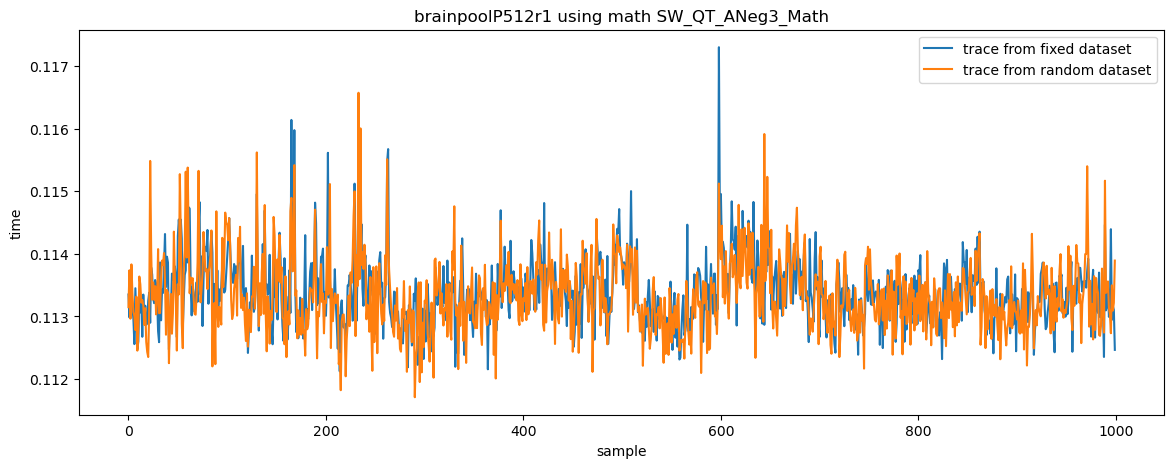

In [144]:
plt.figure(figsize=(14,5))
plt.plot(baseline, label='trace from fixed dataset ')
plt.plot(measurement, label='trace from random dataset')
plt.title(data['curve'] + ' using math ' + data['math'])
plt.xlabel('sample')
plt.ylabel('time')
plt.legend()
plt.show()

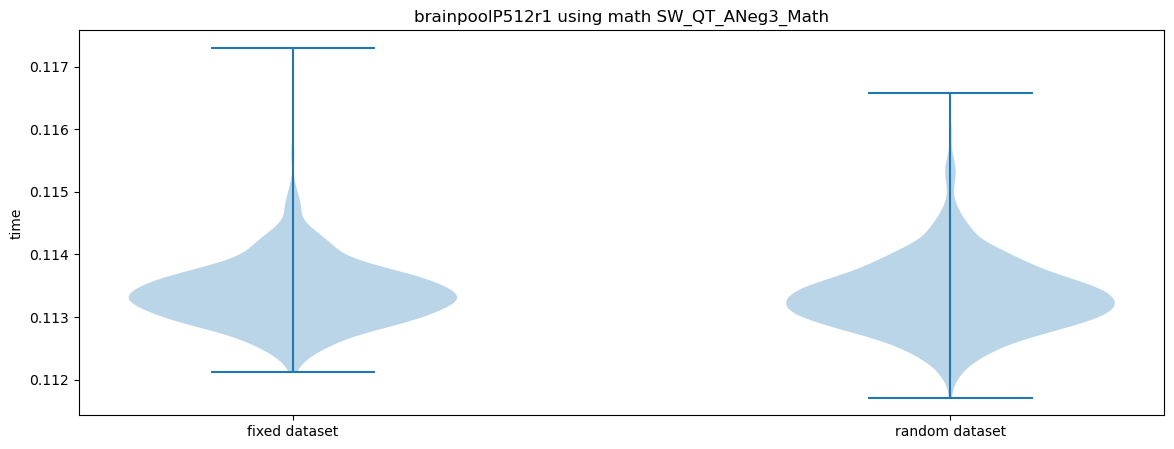

In [145]:
plt.figure(figsize=(14, 5))
plt.violinplot([baseline, measurement])
plt.xticks([1, 2], ['fixed dataset', 'random dataset'])
plt.title(data['curve'] + ' using math ' + data['math'])
plt.ylabel('time')
plt.show()

## 3. Perform t-test

When visually all looks well, we try to quantify the result.

Our 0-hypothesis is that the code is constant-time, which we reject if the p-value is lower than 0.05. Hence:
- If the p-value is higher than 0.05 all is fine (we expect the code to be constant time).
- Otherwise, we must investigate why it is not observably constant time.

In [146]:
 # equal_var=False ensures we do not assume equal variance between the two testsets
result=ss.ttest_ind(baseline, measurement, axis=0, equal_var=False)

# probability of observing this data if null-hypothesis (const-time) is true. If below 0.05, then const-time is broken.
print(f"P-value: {result.pvalue}")

P-value: 0.02185684254671179
